Diabetic Retinopathy Disease Classification

1) Import Needed Modules

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [2]:
data = pd.read_csv("DR_grading.csv")
data

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0
...,...,...
12517,007-6761-400.jpg,4
12518,007-6762-400.jpg,4
12519,007-6763-400.jpg,4
12520,007-6764-400.jpg,4


In [3]:
#DR severity: none, mild, moderate, severe, and proliferative DR.

dataset_folder = "Diabetic_Dataset"
#os.mkdir(dataset_folder)

try:
    os.mkdir(dataset_folder)
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/0")
except:
    pass # Folder already available


try:
    os.mkdir(dataset_folder+"/1")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/2")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/3")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/4")
except:
    pass # Folder already available


In [6]:

main_folder = "./Diabetic_Dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['0', '1', '2', '3', '4'] 5


In [4]:
import shutil
base_path = "./DR_grading/"
for row in data.values:
    img_name = str(row[0])
    img_class = str(row[1])
    img_path = base_path + img_name #Current Image Path
    final_path = dataset_folder + "/" + img_class+ "/"+ img_name #Folder to which Image should be Copied
    print(img_name, img_class, img_path)
    shutil.copyfile(img_path, final_path) # Copy the Image to suitable Class folder
    print("Moved Image: ", img_path , "---->", final_path)
    
    

20170413102628830.jpg 0 ./DR_grading/20170413102628830.jpg
Moved Image:  ./DR_grading/20170413102628830.jpg ----> Diabetic_Dataset/0/20170413102628830.jpg
20170413111955404.jpg 0 ./DR_grading/20170413111955404.jpg
Moved Image:  ./DR_grading/20170413111955404.jpg ----> Diabetic_Dataset/0/20170413111955404.jpg
20170413112015395.jpg 0 ./DR_grading/20170413112015395.jpg
Moved Image:  ./DR_grading/20170413112015395.jpg ----> Diabetic_Dataset/0/20170413112015395.jpg
20170413112017305.jpg 0 ./DR_grading/20170413112017305.jpg
Moved Image:  ./DR_grading/20170413112017305.jpg ----> Diabetic_Dataset/0/20170413112017305.jpg
20170413112528859.jpg 0 ./DR_grading/20170413112528859.jpg
Moved Image:  ./DR_grading/20170413112528859.jpg ----> Diabetic_Dataset/0/20170413112528859.jpg
20170413112758639.jpg 0 ./DR_grading/20170413112758639.jpg
Moved Image:  ./DR_grading/20170413112758639.jpg ----> Diabetic_Dataset/0/20170413112758639.jpg
20170413112758698.jpg 0 ./DR_grading/20170413112758698.jpg
Moved Image

### 2) Data loading

In [5]:
main_folder = "./Diabetic_Dataset"
RANDOM_SEED = 11
categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))

['0', '1', '2', '3', '4'] 5


In [6]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)


              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 0


100%|██████████| 6266/6266 [07:51<00:00, 13.28it/s]


1 1


100%|██████████| 630/630 [00:32<00:00, 19.40it/s]


2 2


100%|██████████| 4477/4477 [03:48<00:00, 19.61it/s]


3 3


100%|██████████| 236/236 [00:10<00:00, 21.50it/s]


4 4


100%|██████████| 913/913 [01:00<00:00, 15.20it/s]


Total Images Loaded: 12522


In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
np.random.seed(RANDOM_SEED)
n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Image normalization

In [9]:
images = images.astype(np.float16)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ", images.shape)

Images shape after normalization =  (12522, 224, 224, 3)


- Split dataset for training and testing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (10017, 224, 224, 3)
y_train shape =  (10017,)

x_test shape =  (2505, 224, 224, 3)
y_test shape =  (2505,)


In [11]:
del(images)
del(labels)

In [12]:
EPOCHS = 15
BATCH_SIZE = 32

# RESNET 50 v2

In [13]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [14]:
#do not train the pre-trained layers
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [15]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [17]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=10, restore_best_weights=True)

In [18]:
# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/15
313/313 [==============================] - 1042s 3s/step - loss: 1.2380 - acc: 0.5678 - val_loss: 0.9611 - val_acc: 0.6230
Epoch 2/15
313/313 [==============================] - 985s 3s/step - loss: 0.8436 - acc: 0.6970 - val_loss: 0.7768 - val_acc: 0.7039
Epoch 3/15
313/313 [==============================] - 994s 3s/step - loss: 0.7362 - acc: 0.7316 - val_loss: 0.7378 - val_acc: 0.7175
Epoch 4/15
313/313 [==============================] - 976s 3s/step - loss: 0.6512 - acc: 0.7681 - val_loss: 0.7353 - val_acc: 0.7292
Epoch 5/15
313/313 [==============================] - 962s 3s/step - loss: 0.5809 - acc: 0.7900 - val_loss: 0.7255 - val_acc: 0.7220
Epoch 6/15
313/313 [==============================] - 978s 3s/step - loss: 0.5089 - acc: 0.8191 - val_loss: 0.8118 - val_acc: 0.7179
Epoch 7/15
313/313 [==============================] - 996s 3s/step - loss: 0.4452 - acc: 0.8450 - val_loss: 0.8866 - val_acc: 0.6875
Epoch 8/15
313/313 [==============================] - 950s 3s/step -

In [19]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32) 
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

79/79 [==============================] - 197s 2s/step - loss: 1.1968 - acc: 0.7246
Resnet_50_V2 Loss: 1.1968269348144531
Resnet_50_V2 Accuracy: 72.45509028434753 %


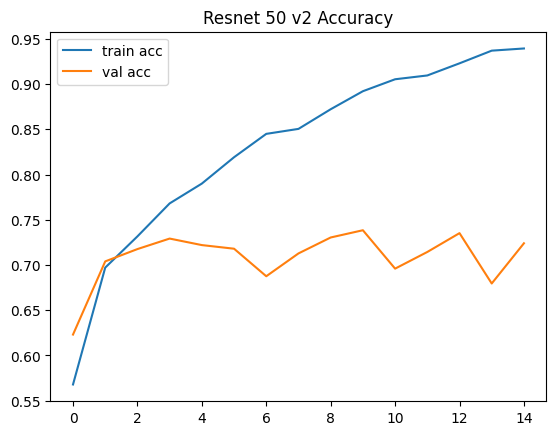

In [20]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

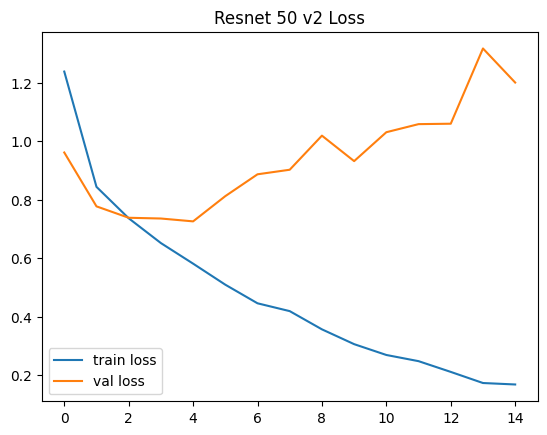

In [21]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [22]:

y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

print(classification_report(y_pred,y_test))

79/79 [==============================] - 190s 2s/step
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1319
           1       0.18      0.17      0.17       124
           2       0.67      0.69      0.68       875
           3       0.11      0.45      0.18        11
           4       0.62      0.65      0.64       176

    accuracy                           0.72      2505
   macro avg       0.49      0.56      0.50      2505
weighted avg       0.73      0.72      0.73      2505



In [23]:
print(confusion_matrix(y_pred,y_test)) #get confusion matrix

resnet_50_v2_model.save("./diabetic_retinopathy_resnet_50v2_model.h5", save_format="h5")

[[1072   53  183    3    8]
 [  44   21   58    1    0]
 [ 140   41  602   34   58]
 [   1    0    1    5    4]
 [   7    1   51    2  115]]
